# Project - Sales Forecasting Accuracy Increasing 

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from scipy.optimize import minimize
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('For USML.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
Period        81 non-null int64
Forecast 1    81 non-null int64
Actual 1      81 non-null int64
Forecast 2    81 non-null int64
Actual 2      81 non-null int64
Forecast 3    81 non-null int64
Actual 3      81 non-null int64
Forecast 4    81 non-null int64
Actual 4      81 non-null int64
Forecast 5    81 non-null int64
Actual 5      81 non-null int64
Forecast 6    81 non-null int64
Actual 6      81 non-null int64
dtypes: int64(13)
memory usage: 8.3 KB


In [3]:
data.describe()

,Period,Forecast 1,Actual 1,Forecast 2,Actual 2,Forecast 3,Actual 3,Forecast 4,Actual 4,Forecast 5,Actual 5,Forecast 6,Actual 6
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,41.000000,9056.345679,8701.000000,878.074074,992.444444,3416.753086,3237.037037,891.358025,881.888889,48.876543,165.148148,57.925926,105.925926
std,23.526581,2793.121874,2573.329633,463.331193,705.503774,1032.982424,1084.246391,380.930220,645.320754,70.220792,360.988300,80.966162,160.372830
min,1.000000,2940.000000,3885.000000,269.000000,72.000000,1500.000000,858.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6830.000000,6867.000000,525.000000,537.000000,2640.000000,2382.000000,600.000000,408.000000,0.000000,42.000000,0.000000,12.000000
50%,41.000000,9150.000000,8109.000000,840.000000,834.000000,3300.000000,3345.000000,870.000000,738.000000,0.000000,90.000000,0.000000,51.000000
75%,61.000000,10620.000000,10611.000000,1050.000000,1311.000000,4050.000000,3762.000000,1095.000000,1182.000000,90.000000,156.000000,120.000000,120.000000
max,81.000000,15150.000000,15396.000000,3099.000000,3966.000000,5850.000000,7365.000000,1827.000000,3270.000000,426.000000,3180.000000,291.000000,879.000000


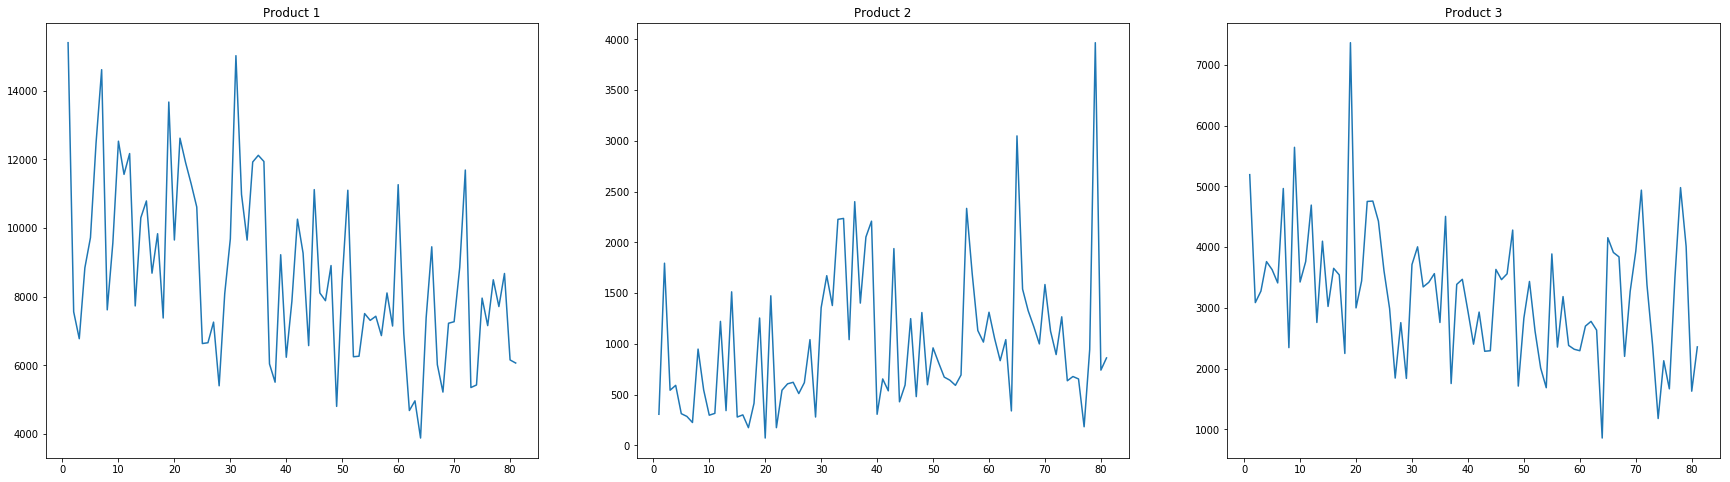

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 1"]);
axes[0].set_title("Product 1");
axes[1].plot(data["Period"],data["Actual 2"]);
axes[1].set_title("Product 2");
axes[2].plot(data["Period"],data["Actual 3"]);
axes[2].set_title("Product 3");

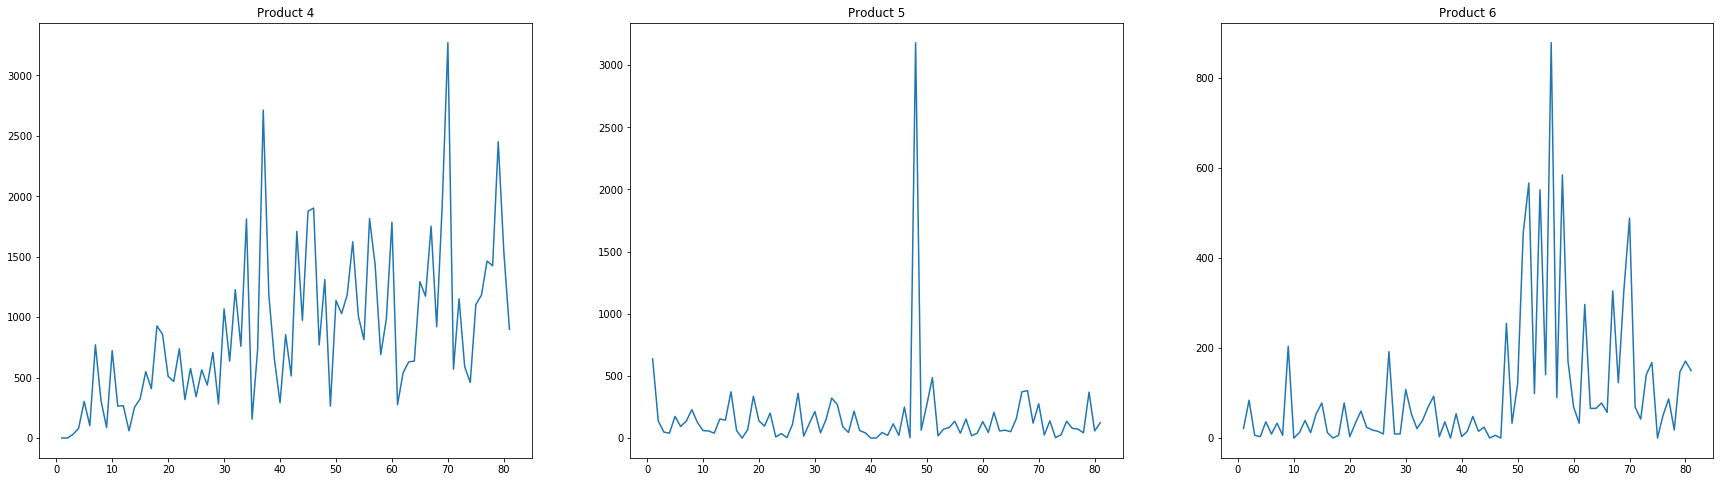

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 8));
axes[0].plot(data["Period"],data["Actual 4"]);
axes[0].set_title("Product 4");
axes[1].plot(data["Period"],data["Actual 5"]);
axes[1].set_title("Product 5");
axes[2].plot(data["Period"],data["Actual 6"]);
axes[2].set_title("Product 6");

# ARIMA Product #2

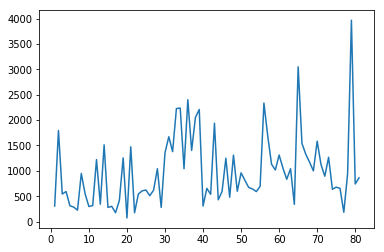

In [17]:
#We can see that Sales dataset has a clear trend. This suggests that the time series is not stationary and 
#will require differencing to make it stationary, at least a difference order of 1.
plt.plot(data["Period"],data["Actual 2"]);

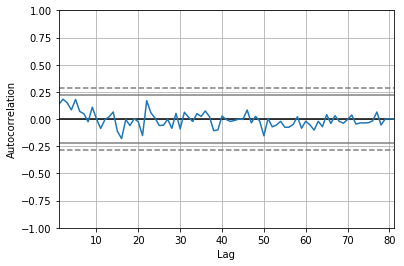

In [18]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Let’s also take a quick look at an autocorrelation plot of the time series. 
#We can see that there is no significant correlation with the lags 
#A good starting point for the AR parameter of the model may be 0.
autocorrelation_plot(data["Actual 2"]);

count      81.000000
mean      992.444444
std       705.503774
min        72.000000
25%       537.000000
50%       834.000000
75%      1311.000000
max      3966.000000
Name: Actual 2, dtype: float64

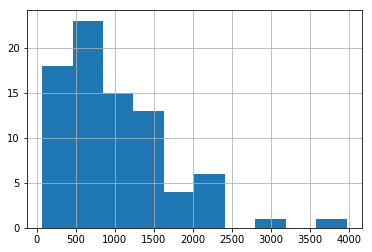

In [19]:
itog1 = data["Actual 2"].describe()
data["Actual 2"].hist()
itog1

Как можно заметить из характеристик и гистограммы, ряд у нас не однородный и имеет относительно 
большой разброс о чем свидетельствует коэффициент вариации: LaTeX:V = \frac {\sigma}{\bar{x}}, где 
        LaTeX:\sigma — cреднеквадратическое отклонение, LaTeX:\bar{x} — среднее арифметическое выборки. В нашем случае он равен:

In [20]:
print("V = %f" % (itog1['std']/itog1['mean']))

V = 0.710875


Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [21]:
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data["Actual 2"])
a = np.vstack([jb_test])
itog1 = SimpleTable(a, row)
print (itog1)

        JB               p-value               skew             kurtosis    
----------------------------------------------------------------------------
62.37357238490917 2.855951634005895e-14 1.4981450049511418 6.082743041672027
----------------------------------------------------------------------------


#https://habr.com/post/207160/
#Значение данной статистика свидетельствует о том, нулевая гипотеза о нормальности распределения
#отвергается с большой вероятностью (probably > 0.05), и, следовательно, наш ряд НЕ имеет нормального распределения.

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [22]:
test = sm.tsa.adfuller(data["Actual 2"])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.7573835175352155
p-value:  9.656309885624832e-12
Critical values:  {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}
единичных корней нет, ряд стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [23]:
ts1 = data["Actual 2"].diff(periods=1).dropna()

В коде выше функция diff() вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр period. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод dropna().
Проверим получившийся ряд на стационарность:


In [24]:
test = sm.tsa.adfuller(ts1)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.342587719717563
p-value:  1.0556544723809156e-10
Critical values:  {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}
единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [25]:
m = ts1.index[int(len(ts1.index)/2+1)]
r1 = sm.stats.DescrStatsW(ts1[m:])
r2 = sm.stats.DescrStatsW(ts1[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.7492943116953179


Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

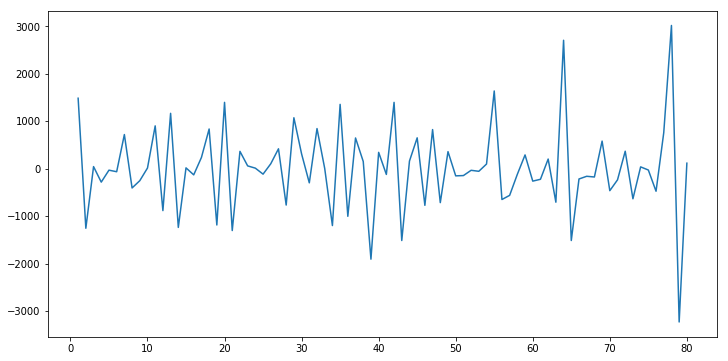

In [26]:
ts1.plot(figsize=(12,6));

Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.
Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

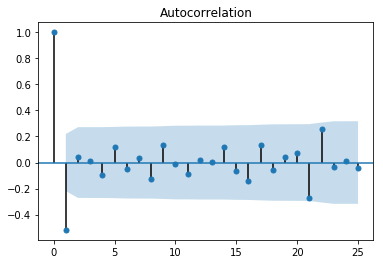

In [27]:
#ig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts1,lags=25);

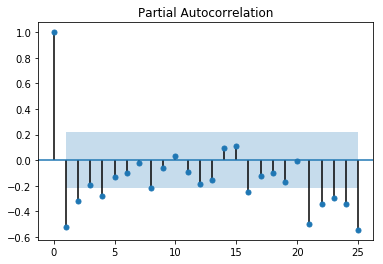

In [28]:
#ax2 = fig.add_subplot(212)
plot_pacf(ts1, lags=25);

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

In [33]:
ts1_model = data["Actual 2"][:70]
model1 = sm.tsa.ARIMA(ts1_model, order=(0,1,1)).fit(disp=0)

In [34]:
print (model1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Actual 2   No. Observations:                   69
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -542.586
Method:                       css-mle   S.D. of innovations            624.350
Date:                Tue, 19 Mar 2019   AIC                           1091.172
Time:                        16:54:28   BIC                           1097.875
Sample:                             1   HQIC                          1093.831
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.9645     14.889      0.736      0.464     -18.218      40.147
ma.L1.D.Actual 2    -0.8153      0.103     -7.894      0.000      -1.018      -0.613
                            

Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [52]:
q_test = sm.tsa.stattools.acf(model1.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.192156  0.661128
1    1.157156  0.560695
2    1.163461  0.761780
3    1.481962  0.829832
4    2.785759  0.732974
5    3.117471  0.793965
6    3.125858  0.873120
7    5.847899  0.664265
8    6.251784  0.714478
9    6.265423  0.792492
10   8.355787  0.681123
11   8.355787  0.756746
12   8.517763  0.808312
13  10.310423  0.739154
14  10.585788  0.781367
15  17.094894  0.379482
16  17.726322  0.406300
17  17.806140  0.468491
18  17.971843  0.524320
19  18.143099  0.577982
20  23.247447  0.330928
21  27.807509  0.182149
22  28.255142  0.206287
23  28.974448  0.221094
24  29.260096  0.253190
25  29.336653  0.295997
26  29.425467  0.340576
27  31.292324  0.304254
28  33.741065  0.248865
29  35.915103  0.210870
30  36.651318  0.223087
31  37.851301  0.219668
32  39.102754  0.214674
33  41.105550  0.187354
34  42.351704  0.183463
35  42.351708  0.215889
36  44.864957  0.175455
37  45.120292  0.198742
38  45.468902  0.220630
39  46.089578  0.234905


Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
Теперь давайте расчитаем коэффициент детерминацииLaTeX:R^2, чтобы понять какой процент наблюдений описывает данная модель:

In [53]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
pred1 = model1.predict(69,80,typ="levels")
trn1 = data["Actual 2"][69:]
r2 = r2_score(trn1, pred1)
print ('R^2: %1.2f' % r2)

R^2: -0.11


In [54]:
pred1.shape

(12,)

In [55]:
trn1.shape

(12,)

In [56]:
mean_squared_error(trn1,pred1)

936686.8131530356

In [57]:
mean_absolute_error(trn1,pred1)

760.9113167840686

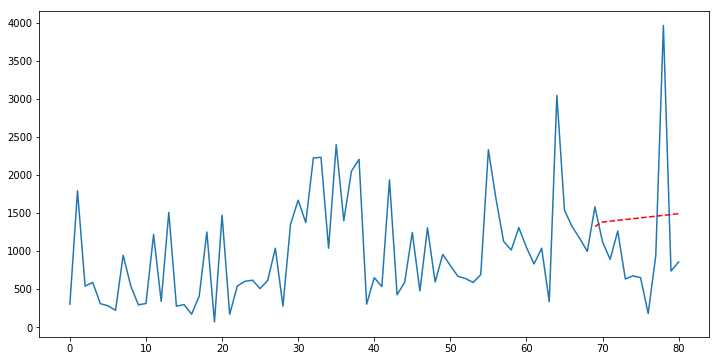

In [58]:
data["Actual 2"].plot(figsize=(12,6))
pred1.plot(style='r--');

# MAPE, GMRAE, UMBRAE

In [80]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [81]:
round(mean_absolute_percentage_error(trn1, pred1), 2)

120.35

In [82]:
def gmrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 2"][68:80])
    return (np.prod(np.abs((y_true - y_pred)/(y_true - y_true1))))**(1/len(y_true))

In [83]:
round(gmrae(trn1, pred1), 2)

1.6

In [84]:
len(trn1)

12

In [85]:
np.array(trn1)

array([1584, 1125,  894, 1266,  636,  678,  654,  183,  945, 3966,  741,
        861])

In [86]:
data["Actual 2"][68:80]

68     999
69    1584
70    1125
71     894
72    1266
73     636
74     678
75     654
76     183
77     945
78    3966
79     741
Name: Actual 2, dtype: int64

In [87]:
pred1

69    1326.114277
70    1384.714960
71    1395.679459
72    1406.643957
73    1417.608455
74    1428.572954
75    1439.537452
76    1450.501950
77    1461.466449
78    1472.430947
79    1483.395446
80    1494.359944
dtype: float64

In [90]:
def umbrae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true1 = np.array(data["Actual 2"][68:80])
    return (np.sum(np.abs(y_true - y_pred)/(np.abs(y_true - y_pred)+np.abs(y_true - y_true1))))/len(y_true)

In [91]:
round(umbrae(trn1, pred1), 2)

0.56

### DOUBLE Exponentional smoothing Product #1

In [92]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

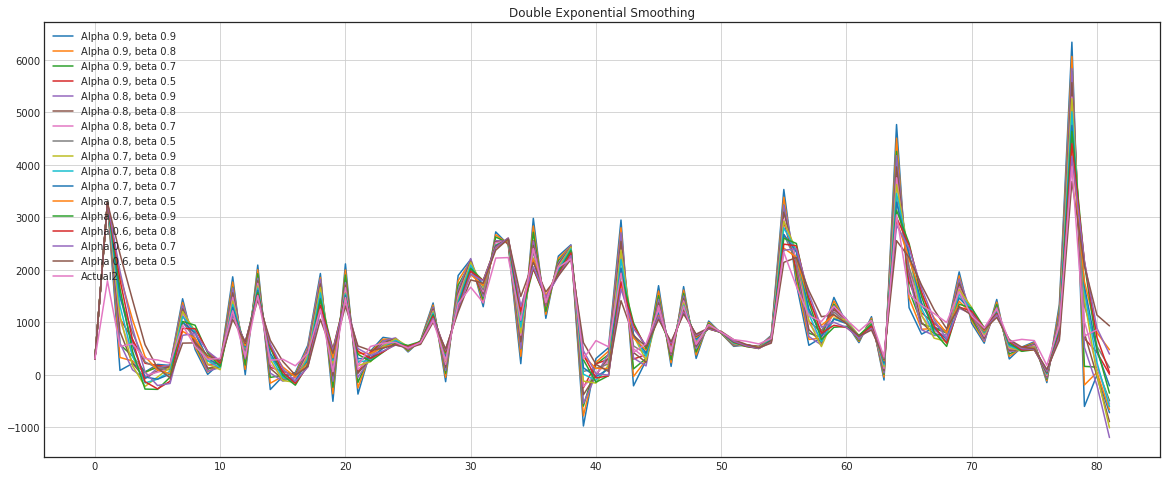

In [93]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.8,0.7,0.6]:
        for beta in [0.9, 0.8,0.7,0.5]:
            plt.plot(double_exponential_smoothing(data["Actual 2"], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(data["Actual 2"].values, label = "Actual2")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Now we have to tune two parameters — α and β. The former is responsible for the series smoothing around trend, and the latter for the smoothing of the trend itself. The bigger the values, the more weight the latest observations will have and the less smoothed the model series will be. Combinations of the parameters may produce really weird results, especially if set manually. We’ll look into choosing parameters automatically in a bit, immediately after triple exponential smoothing.

In [94]:
double_exponential_smoothing(data["Actual 2"],0.9,0.1)[69:81]

[1556.7059688986446,
 1160.789116043042,
 889.2864103136079,
 1230.8403628124397,
 644.4601254092033,
 626.6406903820514,
 605.7210847449517,
 141.684226554196,
 853.3789603452428,
 3923.584327293276,
 1041.672274531684,
 845.2205645476733]

In [96]:
data["Actual 2"][69:81]

69    1584
70    1125
71     894
72    1266
73     636
74     678
75     654
76     183
77     945
78    3966
79     741
80     861
Name: Actual 2, dtype: int64

In [97]:
for alpha in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
        for beta in [0.9, 0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
            mape=mean_absolute_percentage_error(data["Actual 2"][69:81], double_exponential_smoothing(data["Actual 2"],alpha,beta)[69:81])
            print(alpha,"  ",beta,"  ", round(mape,3))

0.9    0.9    60.194
0.9    0.8    50.562
0.9    0.7    41.37
0.9    0.6    32.773
0.9    0.5    24.887
0.9    0.4    20.817
0.9    0.3    17.651
0.9    0.2    13.854
0.9    0.1    8.354
0.8    0.9    39.075
0.8    0.8    32.311
0.8    0.7    29.994
0.8    0.6    27.107
0.8    0.5    25.081
0.8    0.4    22.654
0.8    0.3    19.362
0.8    0.2    16.152
0.8    0.1    13.392
0.7    0.9    35.552
0.7    0.8    33.155
0.7    0.7    31.189
0.7    0.6    28.781
0.7    0.5    26.017
0.7    0.4    24.379
0.7    0.3    23.706
0.7    0.2    21.446
0.7    0.1    21.541
0.6    0.9    35.928
0.6    0.8    33.278
0.6    0.7    31.369
0.6    0.6    31.523
0.6    0.5    31.668
0.6    0.4    30.819
0.6    0.3    28.921
0.6    0.2    27.038
0.6    0.1    28.623
0.5    0.9    40.139
0.5    0.8    40.317
0.5    0.7    39.938
0.5    0.6    38.907
0.5    0.5    37.157
0.5    0.4    35.187
0.5    0.3    32.919
0.5    0.2    32.948
0.5    0.1    35.321
0.4    0.9    47.573
0.4    0.8    45.708
0.4    0.7    4

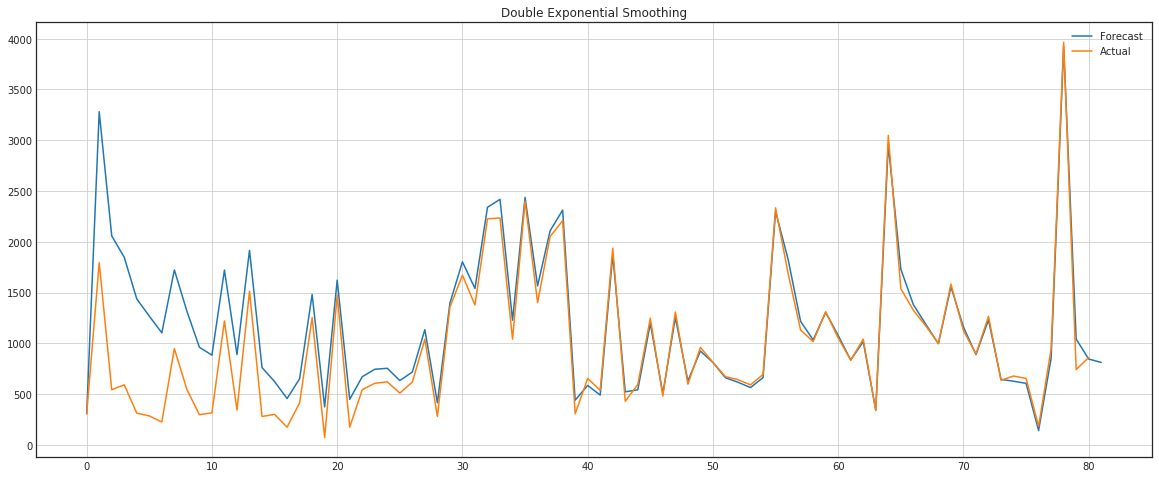

In [98]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(double_exponential_smoothing(data["Actual 2"], 0.9, 0.1), label = "Forecast");
    plt.plot(data["Actual 2"].values, label = "Actual");
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [99]:
round(mean_absolute_percentage_error(data["Actual 2"][69:81], 
                                     double_exponential_smoothing(data["Actual 2"],0.9,0.1)[69:81]),2)

8.35

In [100]:
round(gmrae(data["Actual 2"][69:81], 
                                     double_exponential_smoothing(data["Actual 2"],0.9,0.1)[69:81]),2)

0.09

In [101]:
round(umbrae(data["Actual 2"][69:81], 
                                     double_exponential_smoothing(data["Actual 2"],0.9,0.1)[69:81]),2)

0.15

## LINEAR REGRESSION

In [102]:
# Creating a copy of the initial datagrame to make various transformations 
xg = pd.DataFrame(data["Actual 2"].copy())
xg.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 13):
    xg["lag_{}".format(i)] = xg.y.shift(i)

In [103]:
xg.head(13)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1794,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,543,1794.0,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,591,543.0,1794.0,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,312,591.0,543.0,1794.0,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,285,312.0,591.0,543.0,1794.0,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,225,285.0,312.0,591.0,543.0,1794.0,306.0,NaN,NaN,NaN,NaN,NaN,NaN
7,948,225.0,285.0,312.0,591.0,543.0,1794.0,306.0,NaN,NaN,NaN,NaN,NaN
8,546,948.0,225.0,285.0,312.0,591.0,543.0,1794.0,306.0,NaN,NaN,NaN,NaN
9,297,546.0,948.0,225.0,285.0,312.0,591.0,543.0,1794.0,306.0,NaN,NaN,NaN


In [104]:
xg=xg.dropna()

In [105]:
y = xg["y"]
X = xg.drop(["y"], axis=1)

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [107]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [108]:
# reserve 15% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.17)

In [109]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

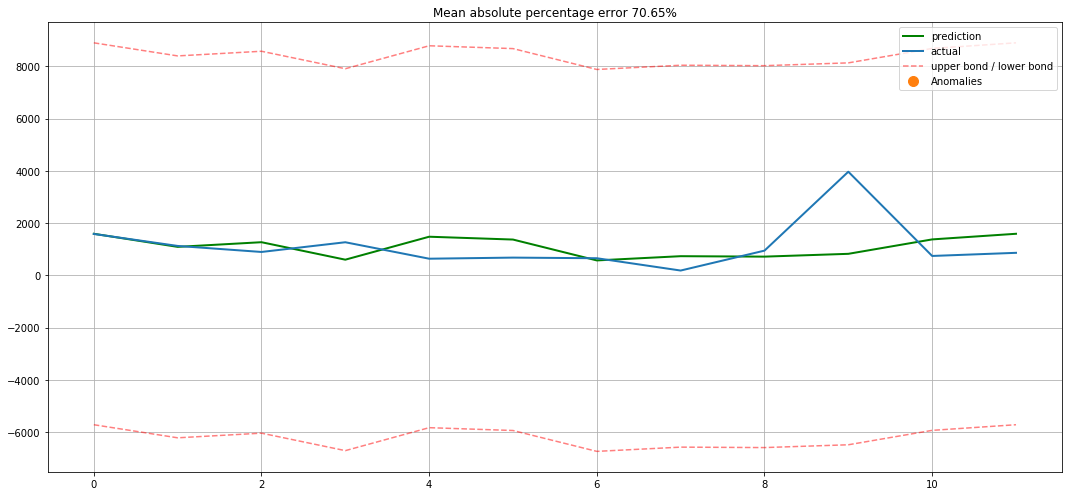

In [110]:
plotModelResults(lr, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [111]:
prediction = lr.predict(X_test)
print (prediction)

[1590.27561693 1089.31503503 1267.57648102  598.65877645 1477.61457762
 1369.30788363  570.22280324  732.30602299  715.51592411  822.72150277
 1374.70019279 1590.25389192]


In [112]:
print (y_test)

69    1584
70    1125
71     894
72    1266
73     636
74     678
75     654
76     183
77     945
78    3966
79     741
80     861
Name: y, dtype: int64


In [113]:
round(mean_absolute_percentage_error(y_test, prediction),2)

76.59

In [114]:
round(gmrae(y_test, prediction), 2)

0.81

In [115]:
round(umbrae(y_test, prediction), 2)

0.49

## XGBOOST 

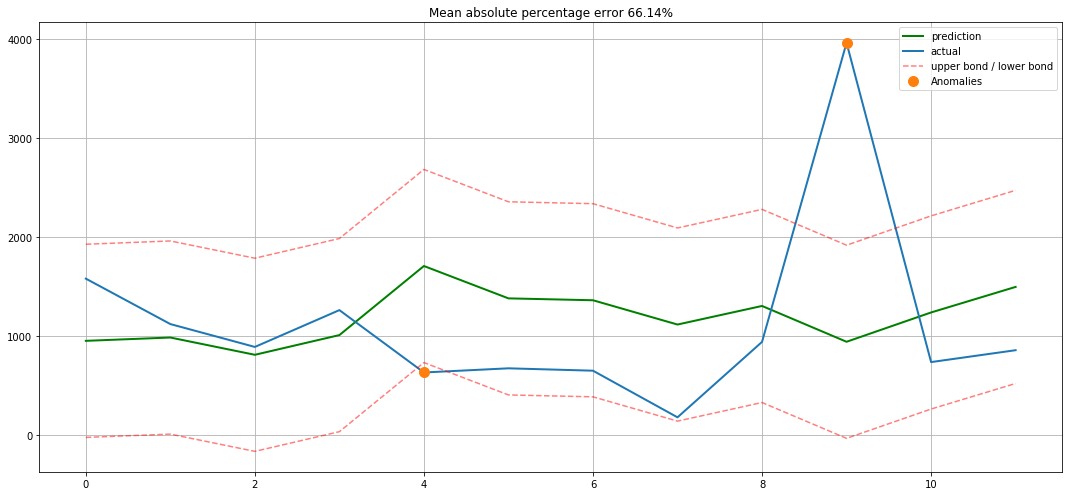

In [116]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

In [117]:
prediction1 = xgb.predict(X_test)
print (prediction1)

[ 955.61926  989.0553   814.6098  1013.6751  1711.5323  1384.6292
 1365.5846  1120.2639  1307.9856   946.1503  1242.245   1500.4612 ]


In [118]:
round(mean_absolute_percentage_error(y_test, prediction1),2)

102.61

In [119]:
round(gmrae(y_test, prediction1), 2)

1.38

In [120]:
round(umbrae(y_test, prediction1), 2)

0.53

# Facebook Prophet

In [121]:
from fbprophet import Prophet

In [122]:
ph1=pd.read_csv("For USML_date2.csv", sep=";")
ph1.tail(12)

,Date,Actual 1,Actual 2,Actual 3,Actual 4,Actual 5,Actual 6
69,31.07.2017,7272,1584,3933,3270,276,489
70,31.08.2017,8853,1125,4938,570,24,69
71,30.09.2017,11688,894,3381,1152,138,42
72,31.10.2017,5355,1266,2391,591,3,141
73,30.11.2017,5430,636,1179,459,27,168
74,31.12.2017,7959,678,2130,1104,135,0
75,31.01.2018,7158,654,1668,1182,78,51
76,28.02.2018,8493,183,3501,1464,72,87
77,31.03.2018,7713,945,4980,1425,42,18
78,30.04.2018,8676,3966,4011,2451,369,147


In [123]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [124]:
import pandas as pd
ph1 = pd.DataFrame({'ds':ph1['Date'], 'y':ph1["Actual 2"]})

In [125]:
prediction_size = 12
train_df = ph1[:-prediction_size]
train_df.tail(n=3)

,ds,y
66,30.04.2017,1326
67,31.05.2017,1170
68,30.06.2017,999


In [126]:
m = Prophet()
m.fit(train_df)
predictions=12
future = m.make_future_dataframe(periods=predictions, freq='M')
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [127]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
76,2018-02-28,1508.327438,1690.120310,2983.279529,1508.292495,1508.362399,835.312912,835.312912,835.312912,835.312912,835.312912,835.312912,0.0,0.0,0.0,2343.640350
77,2018-03-31,1520.328092,469.043500,1744.164360,1520.286458,1520.370394,-415.091120,-415.091120,-415.091120,-415.091120,-415.091120,-415.091120,0.0,0.0,0.0,1105.236972
78,2018-04-30,1531.941629,1023.810409,2320.673817,1531.892939,1531.990802,119.507033,119.507033,119.507033,119.507033,119.507033,119.507033,0.0,0.0,0.0,1651.448662
79,2018-05-31,1543.942283,902.448522,2207.809102,1543.887385,1544.001983,42.058428,42.058428,42.058428,42.058428,42.058428,42.058428,0.0,0.0,0.0,1586.000711
80,2018-06-30,1555.555820,616.313630,1910.045641,1555.491927,1555.623954,-304.477331,-304.477331,-304.477331,-304.477331,-304.477331,-304.477331,0.0,0.0,0.0,1251.078489


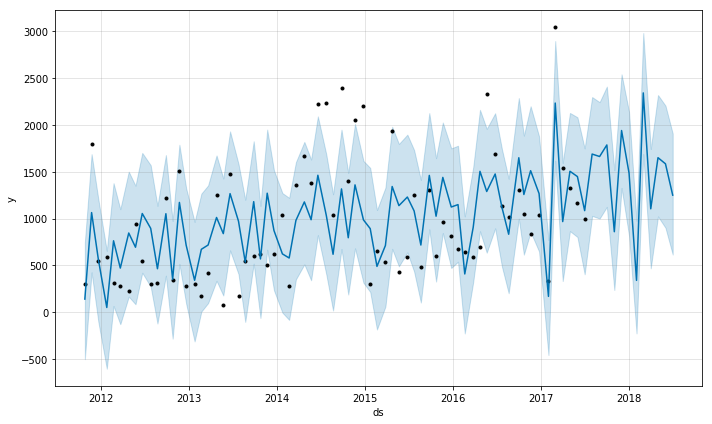

In [128]:
m.plot(forecast);

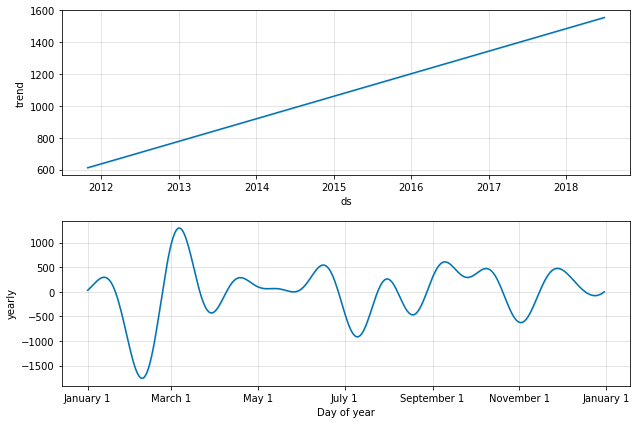

In [129]:
m.plot_components(forecast);

In [130]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index("ds"))

In [131]:
cmp_df = make_comparison_dataframe(ph1, forecast)
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-02-28,2343.640350,1690.120310,2983.279529,183
2018-03-31,1105.236972,469.043500,1744.164360,945
2018-04-30,1651.448662,1023.810409,2320.673817,3966
2018-05-31,1586.000711,902.448522,2207.809102,741
2018-06-30,1251.078489,616.313630,1910.045641,861


In [132]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [133]:
for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 164.5436123511138
MAE 853.5980715931129


In [134]:
cmp_df['y'][-12:]

ds
2017-07-31    1584
2017-08-31    1125
2017-09-30     894
2017-10-31    1266
2017-11-30     636
2017-12-31     678
2018-01-31     654
2018-02-28     183
2018-03-31     945
2018-04-30    3966
2018-05-31     741
2018-06-30     861
Name: y, dtype: int64

In [135]:
cmp_df['yhat'][-12:]

ds
2017-07-31    1690.092277
2017-08-31    1663.949270
2017-09-30    1787.446100
2017-10-31     860.344709
2017-11-30    1941.584253
2017-12-31    1487.207569
2018-01-31     340.265760
2018-02-28    2343.640350
2018-03-31    1105.236972
2018-04-30    1651.448662
2018-05-31    1586.000711
2018-06-30    1251.078489
Name: yhat, dtype: float64

In [136]:
round(mean_absolute_percentage_error(cmp_df['y'][-12:], cmp_df['yhat'][-12:]),2)

164.54

In [137]:
round(gmrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

1.61

In [138]:
round(umbrae(cmp_df['y'][-12:], cmp_df['yhat'][-12:]), 2)

0.58